In [1]:
from keras import models, optimizers, losses
from keras import backend as K
from keras.utils import Progbar
from utils import *
from network import *
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_fn(pred, label):
    plt.figure(figsize=(16, 10))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.xlabel("%f"%(pred[0,...,i].max()))
        plt.imshow(pred[0,...,i], cmap='gray')
        plt.subplot(2, 6, i+1+6)
        plt.title("%f"%(label[0,...,i].max()))
        plt.imshow(label[0,...,i], cmap='gray')
    plt.show()

In [3]:
G = generator(model='vgg', case=1)

print("\n===================================\n")

D = discriminator(model='vgg', case=1)

=========== Information about Backbone ===========
Loading VGG16 model
Total Parameter of Model :  14,713,536
Trainable Parameter of Model :  14,713,536
Non-Trainable Parameter of Model :  0

=========== Information about Whole Network ===========
Total Parameter of Model :  20,601,538
Trainable Parameter of Model :  20,601,538
Non-Trainable Parameter of Model :  0


=========== Information about Backbone ===========
Loading VGG16 model


C:\Users\user\Anaconda3\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 6 input channels.
  str(input_shape[-1]) + ' input channels.')


Total Parameter of Model :  14,716,416
Trainable Parameter of Model :  14,716,416
Non-Trainable Parameter of Model :  0

=========== Information about Whole Network ===========
Total Parameter of Model :  19,437,057
Trainable Parameter of Model :  19,437,057
Non-Trainable Parameter of Model :  0


In [4]:
def Gen2Dis(gen, dis, case=1):
    if case==2:
        dis_out, texture = dis(gen.output)
        net = models.Model(inputs=gen.input, outputs=[gen.output, dis_out, texture])
    else:
        dis_out = dis(gen.output[0])
        net = models.Model(inputs=gen.input, outputs=[gen.output[0], dis_out, gen.output[1]])
    
    return net

In [5]:
def Custom_MSE(y_true, y_pred):
    _mean = K.mean(y_true, axis=-1, keepdims=True)
    return losses.mean_squared_error(_mean, y_pred)

In [6]:
D.trainable=False
A = Gen2Dis(G, D)
A.compile(optimizer=optimizers.Adam(lr=0.0001, epsilon=1e-8), loss=[Custom_MSE, losses.binary_crossentropy, losses.mean_squared_error], loss_weights=[50, 1, 100])

D.trainable=True
D.compile(optimizer=optimizers.Adam(lr=0.0001, epsilon=1e-8), loss=losses.binary_crossentropy)

In [7]:
train_t1, train_dante, val_t1, val_dante = data_loader('../MRI Enhancing/4gan_m')
mask = train_dante.sum(axis=-1, keepdims=True)
mask[mask>0]=1
train_t1 = train_t1*mask

val_mask = val_dante.sum(axis=-1, keepdims=True)
val_mask[val_mask>0]=1
val_t1 = val_t1*val_mask

In [8]:
shuffle_idx = np.random.choice(len(train_t1), len(train_t1), replace=False)
train_t1 = train_t1[shuffle_idx]
train_dante = train_dante[shuffle_idx]
batch = 16
steps = len(train_t1)//batch +1

In [9]:
epochs = 500
#total_progbar = Progbar(epochs)
for epoch in range(epochs):
    epoch_g_style = 0
    epoch_g_texture = 0
    epoch_g_dis = 0
    epoch_d_texture = 0
    epoch_d_dis = 0
    epoch_progbar = Progbar(steps)
    for step in range(steps):
        idx = step*batch
        if step+1 == steps:
            step_train_t1 = train_t1[idx:]
            step_train_dante = train_dante[idx:]
        else:
            step_train_t1 = train_t1[idx:idx+4]
            step_train_dante = train_dante[idx:idx+4]
            
        train_gen_label = np.ones([len(step_train_t1), 1], dtype='float')
        train_dis_label = np.zeros([len(step_train_t1)*2, 1])
        train_dis_label[len(step_train_t1):] = 1.
        
        D.trainable=False
        
        G_Loss = A.train_on_batch(step_train_t1, [step_train_t1, train_gen_label, step_train_dante])
        G_output, _, _ = A.predict(step_train_t1)
        
        D.trainable=True
        train_dis_input = np.concatenate([step_train_dante, G_output], 0)
        D_Loss = D.train_on_batch(train_dis_input, train_dis_label)
        
        epoch_g_style += G_Loss[1]
        epoch_g_texture += G_Loss[3]
        epoch_g_dis +=G_Loss[2]
        
        epoch_d_dis +=D_Loss
        
        epoch_progbar.update(step+1, [("Epochs", epoch+1), ("G_Style", G_Loss[1]), ("G_Texture", G_Loss[3]), ("G_Dis", G_Loss[2]), ("D_Dis", D_Loss)])
    if (epoch+1)%100 == 0:
        A.save('./checkpoint/case1/%03d_%.2f_%.2f_50_100.h5'%(epoch+1, epoch_g_style/steps, epoch_g_texture/steps))
        test_in = train_t1[:1]
        test, _, _ = A.predict(test_in)
        print(test_in.max())

        plot_fn(test, train_dante[:1])
    #total_progbar.update(epoch+1, [("G_Style", epoch_g_style/steps), ("G_Texture", epoch_g_texture/steps), ("G_Dis", epoch_g_dis/steps), ("D_Texture", epoch_d_texture/steps), ("D_Dis", epoch_d_dis/steps)])

19/19 [==============================] - 11s 562ms/step - Epochs: 500.0000 - G_Style: 8239.8922 - G_Texture: 4035.0959 - G_Dis: 1.1921e-07 - D_Dis: 7.9712


1697.5273913145065


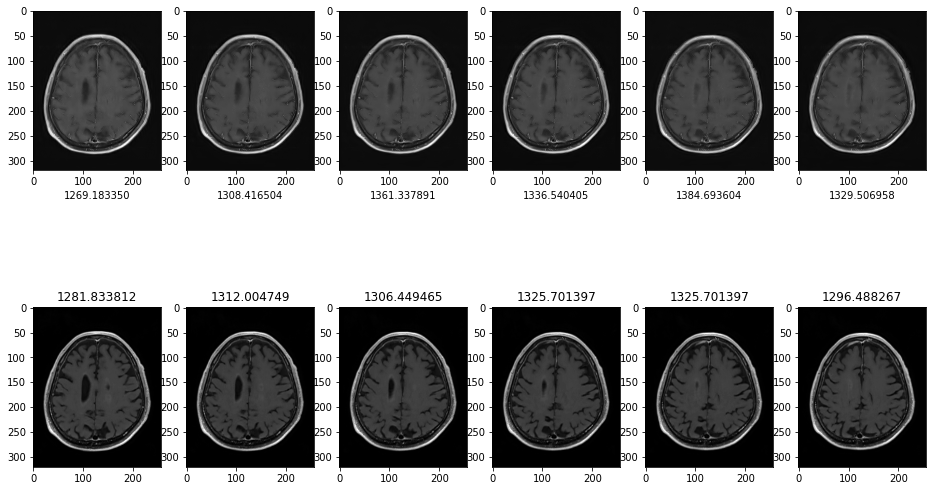

In [10]:
test_in = train_t1[:1]
test, _, _ = A.predict(test_in)
print(test_in.max())

plot_fn(test, train_dante[:1])